<h1 style="color: green;">Deployment pipeline</h1>
<p>
In this section various modules are imported to run the production pipeline to generate a classification score.<br>
The following tasks are accomplished below:
<ul>
<li>Import the pipeline module <b>output_pipeline</b> to preprocess the data and generate the predictions and shap values.</li>
<li>Import the fidelity module <b>local_fidelity</b> to  generate the local explaination plots for the classifier and regressor models.</li>
<li>Display the retrieved data using print()</li>

</ul>
Note, sklearn pipeline was not suitable for the way the code is structured.<br>
</p>

In [1]:
import pandas as pd
# import numpy as np

# import pull_last_7_days_receipts as pull_data
# import derive_item_name_features as derive_features
# import data_transformers
import local_fidelity
import output_pipeline

import warnings
warnings.filterwarnings('ignore')

# display all columns
# pd.set_option('display.max_columns', None)

<h1 style="color: green;">Guest receipt data</h1>
<p>
The guest receipt is the new shopping list before going shopping. It will be added to the data pulled from the database.<br>Then it will all be processed and single prediction will be generated.
</p>

In [2]:
venue_g = 'Asda' # Note, the venue must be an existing venue in the database
Total_Nbr_of_Items_g = 11
Total_Price_g = 15.44
Receipt_Date_g = pd.to_datetime('2023-06-11', format="%Y-%m-%d")

Item_name_g = ['Whole chicken','Garlic pouch','Chopped tomatoes',
               'Chopped tomatoes','Chopped tomatoes','Lemons',
               'Limes','Vimto','Red onions','Peppers mixed','Colgate']
Item_Price_g = [4.98,2.79,0.32,0.32,0.32,0.79,0.79,2.50,0.67,0.97,0.99]

<h1 style="color: green;">Retrieve output using the deployment pipeline</h1>

In [3]:
loaded_pred_class_binarize, loaded_prob, shap_Series_clfier, shap_prediction_clfier,\
Inverse_transf_expenditure_pred, shap_Series_regress, shap_prediction_regress = \
output_pipeline.retrieve_output(venue_g, Total_Nbr_of_Items_g, Total_Price_g, 
                    Receipt_Date_g, Item_name_g, Item_Price_g)

<h1 style="color: green;">Classifier model</h1>

In [4]:
print(f"The model predicts less than 5 shopping trips: {loaded_pred_class_binarize[0]== 1} \
      \nWith a probability of: {'{:.3f}'.format(round(loaded_prob[0],3))}")

The model predicts less than 5 shopping trips: True       
With a probability of: 1.000


In [5]:
print("The model summary shap prediction is: {0:.3f}".format(shap_prediction_clfier))

The model summary shap prediction is: 7.815


<h3 style="color: green;">Explaining the classifier model prediction with shap values</h3>

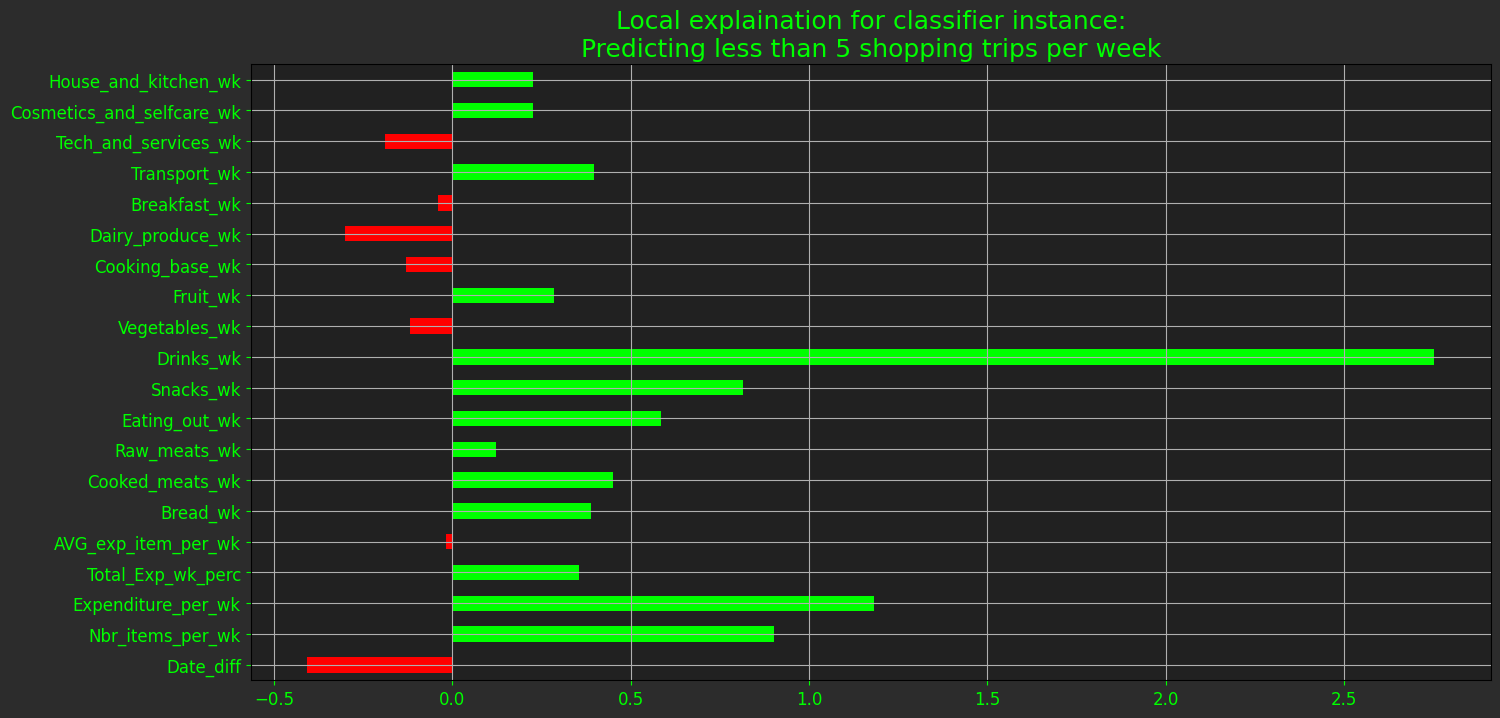

In [6]:
local_fidelity.classifier_local_fidelity(shap_Series_clfier)

<h1 style="color: green;">Regressor model</h1>

In [7]:
Inverse_transf_expenditure_pred[0,0]

17.25072051442318

In [8]:
shap_prediction_regress

array([-0.39751736])

In [9]:
print("The predicted expenditure for the week is: {0:.3f} \
\nand it's shap prediction value is: {1:.3f}".\
      format(round(Inverse_transf_expenditure_pred[0,0],3), round(shap_prediction_regress[0],3)))

The predicted expenditure for the week is: 17.251 
and it's shap prediction value is: -0.398


<h3 style="color: green;">Explaining the regressor model with shap values</h3>

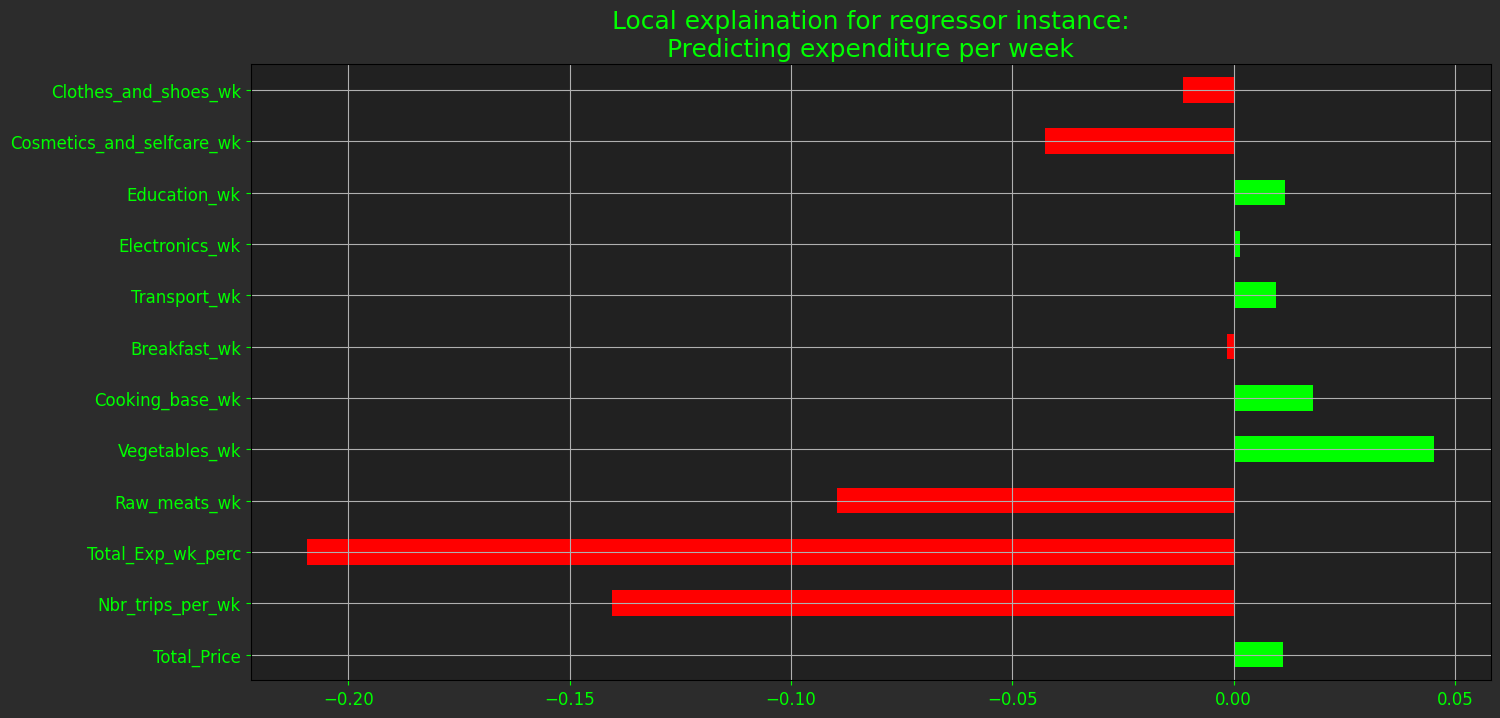

In [10]:
local_fidelity.regressor_local_fidelity(shap_Series_regress)

<p>
The regressor model output of £17.25 matches expectation given there is nothing in the database for the current week.<br> The Total_Price which is the main driver of the explainer is at £15.44.<br><br>
Looking at the SHAP local explainer for both the regressor and classifier they are reciprocal complements as expected<br>i.e. the classifier prediction is of less than 5 shopping trips for the week hence lots of positive drivers,<br> green bars, while for the regressor prediction is a low £17.25 for the week and the explainer is dominated<br> by negative drivers.<br><br>
However, it doesn't make any sense as to why features that have a value of zero have none zero SHAP values <br>e.g. for the regressor explainer there is no Clothes_and_shoes_wk on the receipt yet it has a negative shap value.<br>
Note also that Raw_meats_wk is a moderate negative driver when it should be a positive driver i.e. a whole<br> chicken would last atleast 4 days, reducing the need to buy meat hence reducing the chances of going shopping again.

</p>

<b>Overall the explainer for the classifier and regressor look more acceptable in this instance.<br> However at feature level the degree to which a given feature influences the prediction is still questionable </b>